In [130]:
import os
import sys
module_path = os.path.abspath(os.path.join('fede'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import pandas as pd
from client import Client
from supported_modles import Supported_modles
import utils
from fedavg import Fedavg
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import random
from copy import deepcopy
import statistics
import matplotlib.pyplot as plt

In [131]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [132]:
selected_model = Supported_modles.SGD_classifier

In [143]:
clients, test_x, test_y = utils.set_data(selected_model, True, False, False)

Creating node1.
Creating node2.
Creating node3.
Creating node4.
Creating node5.
439683
251723


In [144]:
test_y.sum()

35718.0

In [145]:
f1_before = []
for client in clients:
    client.init_empty_model(0.001, epochs=30)
    try:
        client.train_model(epochs=50)
    except ValueError:
        score = 0
        print(client.name)
        f1_before.append(score)
        continue 
    try: 
        score = client.test_model_f1(y_test=test_y, X_test=test_x)
    except IndexError:
        score = 0
    f1_before.append(score)
    print(score)

0.7771267869697679
0.757663928496793
0.8145436021522493
0.47104627034889945
0.6589333184615098


In [146]:
fedavg = Fedavg("global", selected_model)

[Errno 98] Address already in use
Waitiing for a Connection..


In [147]:
# clients.remove(clients[0])

In [148]:
###First learn model on clients:
def plot(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        round_scores = []
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(0.001,epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
        round_scores.append(score)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            round_scores.append(score)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(round_scores)

    # print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


In [ ]:
###First learn model on clients:
def scores(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(0.001,epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(score)

    print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


0.8141065283922427
--------------------
0.8107539897429364
--------------------
0.8169080604534006
--------------------
0.8463337585808881
--------------------
0.7836504133411611
--------------------
0.8391852865177079
--------------------
0.8393221164085557
--------------------
0.8583624954748402
--------------------
0.8667110358180059
--------------------
0.8035225362260828
--------------------


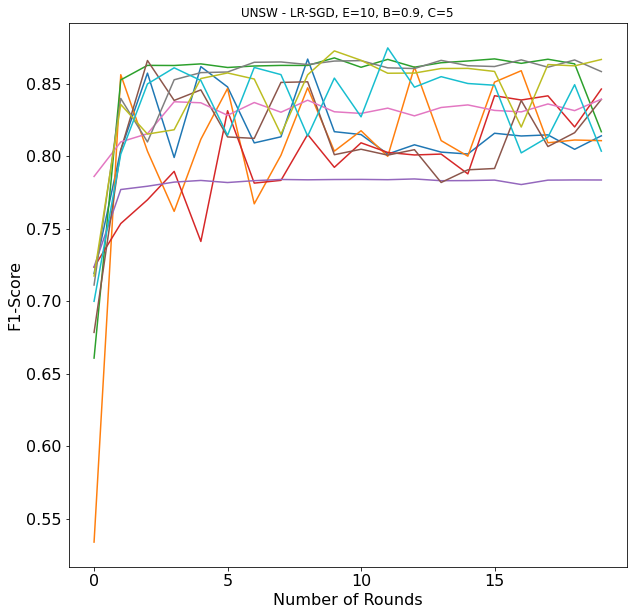

In [149]:
plot(10,0.9,19)

0.8397983050332614
--------------------
0.7954210222535754
--------------------
0.8458926311240083
--------------------
0.8866290894299494
--------------------
0.7952529910671097
--------------------
0.8457156932171557
--------------------
0.8440532404223781
--------------------
0.8417970537103121
--------------------
0.8034869790024591
--------------------
0.8411424018631447
--------------------


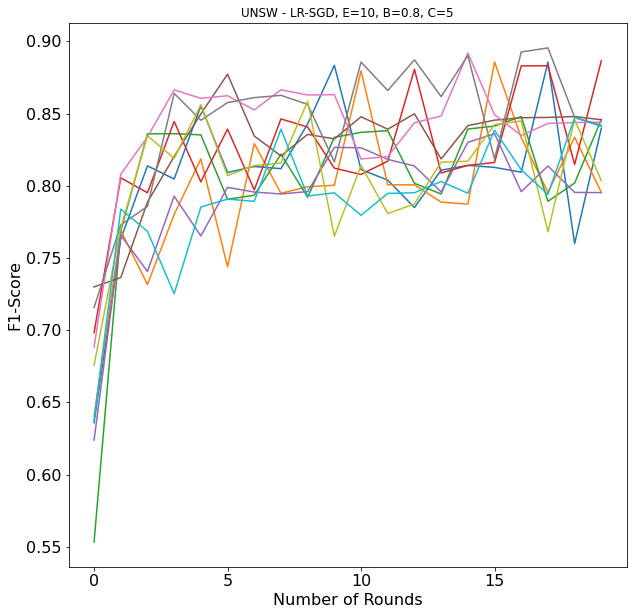

In [150]:
plot(10,0.8,19)

0.8458918434418883
--------------------
0.816089046293954
--------------------
0.8071396783012271
--------------------
0.7884906773848829
--------------------
0.7820817867453443
--------------------
0.81582819397051
--------------------
0.8616447949334713
--------------------
0.7738914809618584
--------------------
0.8115244951264573
--------------------
0.8059486687455025
--------------------


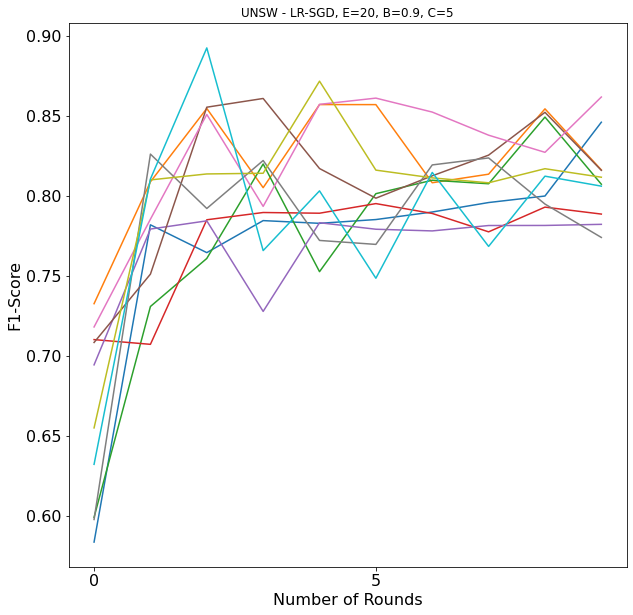

In [151]:
plot(20,0.9,9)

0.7453593211349775
--------------------
0.8268295040763058
--------------------
0.7482256626943518
--------------------
0.844330340671504
--------------------
0.795524951445402
--------------------
0.7987797045600513
--------------------
0.8074599505857974
--------------------
0.8117265294435784
--------------------
0.8295728038507821
--------------------
0.8584611209119284
--------------------


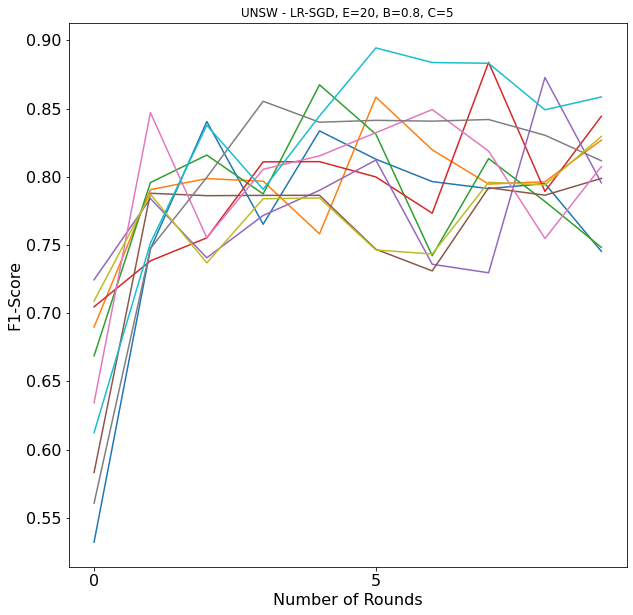

In [152]:
plot(20,0.8,9)